# Maximum Margin Classifier Scratch

✅간략한 설명
* Hyperplane에 의해 공식적으로 정의되는 discriminative classifier
* 레이블이 지정된 훈련 데이터가 주어지면 최적의 hyperplane을 도출함
* d차원 데이터에 대해 두 범주를 잘 구분하는 d-1차원의 hyperplane을 찾음 
* 여러 hyperplane 중 두 class를 나누는 margin이 가장 큰 hyperplane을 찾음 
<br/>

✅한계점
* 데이터가 완벽히 분리되지 않는 경우 사용하기 어려움 
* noisy한 데이터가 있는 경우 너무 민감하게 반응하여 variance가 큰 모델을 만들게 됨 
<br/>

✅학습 목표 
* SVM 개념 이해 및 구현
* 라그랑주 승수와 최적화 이론에 대한 remind  


**자세한 설명은 [README](https://github.com/Moonmoonji/Business_Analytics-2022-/blob/main/Kernel-based%20Learning/README.md)에 나와있습니다** 👌 

✅튜토리얼 구성 
1. [라이브러리 불러오기 및 시각화 함수](#라이브러리-import-및-plotting-모듈)
2. [데이터 생성](#데이터-생성) 
3. [Maximum margin classifier](#maximum-margin-separator)
    - [수식 기반 구현](#maximum-margin-separator-수식-기반-구현)
    - [Scikit Learn으로 구현](#scikit-learn으로-구현)
4. [LDA, Logistic Regression과 비교](#logistic-regression-및-lda와의-비교)

### 라이브러리 import 및 plotting 모듈 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

In [3]:
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

## 데이터 생성 

🧾 가우시안 분포를 따르는 linear하게 separable한 데이터 생성

In [4]:
colors = ['red','green']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N= 100 

In [5]:
def generateBatchBipolar(n, mu=0.5, sigma=0.2):
    """ Two gaussian clouds on each side of the origin """
    X = np.random.normal(mu, sigma, (n, 2))
    yB = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y = 2. * yB - 1
    X *= y[:, np.newaxis]
    X -= X.mean(axis=0)
    return X, y

## Maximum margin separator 

__Maximum margin separator__ 의 목적함수는

$$ \min_{w, b} \frac 12 \Vert w \Vert^2 $$
__Subject to__ : $$y_i(x_i^T w + b) \ge 1, i = 1..n$$ 


목적식과 제약식을 라그랑지안 문제로 변형 : 
$$\mathcal{L}_p(w, b, \alpha) = \frac 12 \Vert w \Vert^2 - \sum_{i=0}^n \alpha_i (y_i(x_i^T w + b) - 1)$$

__Subject to:__
$$\alpha_i \ge 0, i\in 1..n$$

kkt 조건에 의해 다음과 같은 등식을 얻을 수 있음 
$$\begin{align}
\sum_{i=0}^n \alpha_i y_i x_i &= w \\
\sum_{i=0}^n \alpha_i y_i &= 0
\end{align}$$

위의 등식을 사용해서 라그랑지안 문제를 __dual 문제__ 로 변환할 수 있음 

$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k x_i^T x_k \\
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \langle \alpha_i y_i x_i, \alpha_k y_k  x_k \rangle \\
\end{align}$$

__Subject to :__
$$\alpha_i \ge 0, i\in 1..n$$
$$\sum_{i=0}^n \alpha_i y_i = 0$$


### Train data 시각화 

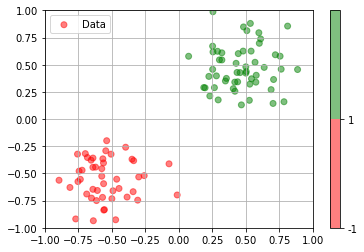

In [6]:
xTrain0, yTrain0 = generateBatchBipolar(N, sigma=0.2)
plotSvm(xTrain0, yTrain0)

### Maximum margin separator 수식 기반 구현

$$\mathcal{L}_d = \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k x_i^T x_k $$

__Subject to :__
- $\sum_{i=0}^n \alpha_i y_i = \langle \alpha, y \rangle = 0$
- $\alpha_i \ge 0, i\in 1..n$


In [7]:
class MaxMarginClassifier:
    
    def __init__(self):
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of (X.y)
        Xy = X * y[:, np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = -np.eye(N)
        b = np.zeros(N)
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        # Any support vector is at a distance of 1 to the separation plan
        # => use support vector #0 to compute the intercept, assume label is in {-1, 1}
        supportLabels = y[self.alpha > epsilon]
        self.intercept = supportLabels[0] - np.matmul(self.supportVectors[0].T, self.w)
    
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        return 2 * (np.matmul(X, self.w) > 0) - 1

In [9]:
model = MaxMarginClassifier()
model.fit(xTrain0, yTrain0)
model.w, model.intercept

(array([1.44521513, 2.49952992]), 0.13493555324315354)

Number of support vectors = 3


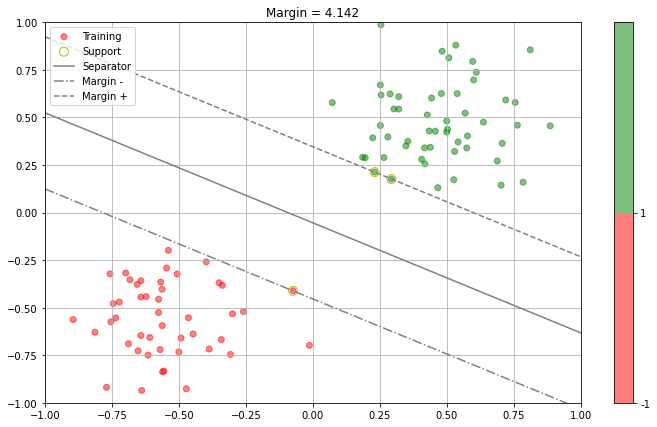

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(xTrain0, yTrain0, model.supportVectors, model.w, model.intercept, label='Training', ax=ax)

### Scikit Learn으로 구현 

In [11]:
model1 = svm.SVC(kernel='linear', gamma='auto', C = 1e6)
model1.fit(xTrain0, yTrain0)
model1.coef_[0], model1.intercept_[0]

(array([1.44496247, 2.4990932 ]), 0.1349702483752771)

Number of support vectors = 3


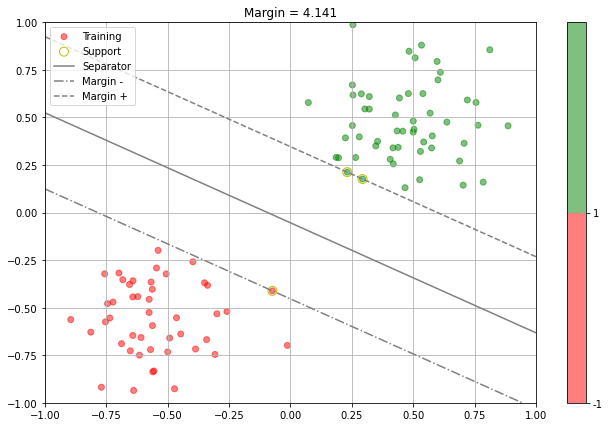

In [12]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain0, yTrain0, model1.support_vectors_, model1.coef_[0], model1.intercept_[0], 
        label='Training', ax=ax)

## Logistic Regression 및 LDA와의 비교 

In [13]:
model2 = linear_model.LogisticRegression(solver='lbfgs')
model2.fit(xTrain0, yTrain0)
model2.coef_[0], model2.intercept_[0]

(array([2.79074159, 2.83507436]), 0.3271919771717465)

In [14]:
model3 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model3.fit(xTrain0, yTrain0)
model3.coef_[0], model3.intercept_[0]

(array([29.6015069 , 25.60209137]), 2.4176938113450728)

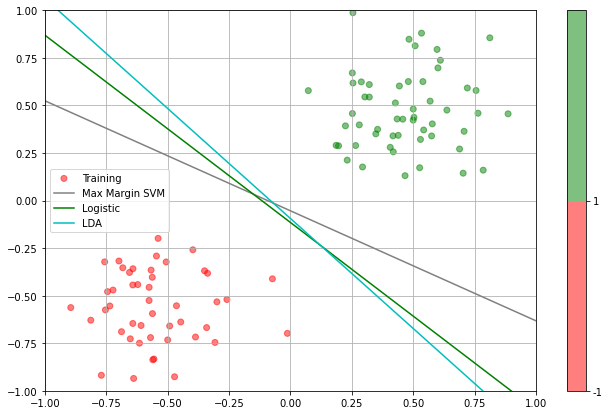

In [17]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain0, yTrain0, w=model1.coef_[0], intercept=model1.intercept_[0], 
        separatorLabel='Max Margin SVM', label='Training', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model2.coef_[0], x0=model2.intercept_[0], label='Logistic', color='g')
plotLine(ax, xx, w=model3.coef_[0], x0=model3.intercept_[0], label='LDA', color='c')
ax.legend();

🔎 결과 해석 :
<br/>
두 데이터 자체가 거리가 서로 멀어서 margin이 큰 상태이다. 따라서 LDA Logistic regression, Maximum margin classifier 모두 두 데이터를 완벽하게 분류했다. <br/>
어느 분류기의 성능이 더 우수하다고 말하기 애매하다.